In [1]:
import cv2 as cv
import numpy as np
import math
import matplotlib.pyplot as plt

In [55]:
# Read image
img = cv.imread('./data/f.jpg')
#img=rot
# Grayscale and black pad one pixel at each side
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# Threshold
_, thresh = cv.threshold(gray, 100, 255, cv.THRESH_BINARY)
#thresh = cv.resize(thresh, (int(thresh.shape[0]/3), int(thresh.shape[1]/3)), interpolation = cv.INTER_AREA)
h, w = img.shape[0], img.shape[1]
# Contours
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
blank = np.zeros((h,w,3), dtype = 'uint8')
cv.drawContours(blank, contours, -1, (0,0,255), 3)
c=[]
for i, cnt in enumerate(contours):
    c.append(cv.contourArea(cnt))
ind = c.index(max(c))
cnt = contours[ind]


# Ellipse
#cnt = contours[21] # Compare cv.contourArea(cnt) to find the right one
ellipse = cv.fitEllipse(cnt)
(x,y),(MA,ma),angle = cv.fitEllipse(cnt)
print(angle)
cv.ellipse(blank, ellipse, (0,255,0), 4)

# Rectangle
#rect = cv.minAreaRect(cnt)
#box = cv.boxPoints(rect)
#box = np.int0(box)
#cv.drawContours(thresh,[box],0,(255,255,255),4)
x,y,w,h = cv.boundingRect(cnt)
cv.rectangle(thresh,(x,y),(x+w,y+h),(255,255,0),2)

# Centroid
M = cv.moments(thresh)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
cv.circle(thresh, (cX, cY), 20, (0, 0, 255), -1)

cv.namedWindow('contour', cv.WINDOW_NORMAL)
cv.imshow('contour', blank)

cv.namedWindow('thresh', cv.WINDOW_NORMAL)
cv.imshow('thresh', thresh)
cv.waitKey(0)

38.9820442199707


-1

In [44]:
x,y,w,h

(743, 1066, 479, 934)

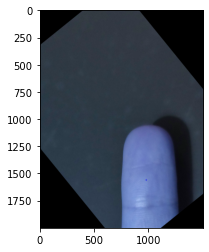

In [45]:
plt.imshow(img)

In [53]:
def rotate(img, angle, rotPoint=None):
    (h,w) = img.shape[:2]
    if rotPoint==None:
        rotPoint = (w//2,h//2)
    rotMat = cv.getRotationMatrix2D(rotPoint, angle, 1.0)
    dimensions = (w,h)
    return cv.warpAffine(img, rotMat, dimensions)

rot = rotate(img, 20)

cv.namedWindow('Rotated', cv.WINDOW_NORMAL)
cv.imshow('Rotated', rot)
cv.waitKey(0)

-1

In [41]:
rect

((517.1350708007812, 1658.7291259765625),
 (483.36822509765625, 1185.7138671875),
 39.93113708496094)

In [28]:
class OrientationCrop:
    
    def __init__(self):
        pass
    
    def findAngle(self, img, display=False):
        '''Finds angle/orientation of finger image'''
        
        # Grayscale
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        # Threshold
        _, thresh = cv.threshold(gray, 100, 255, cv.THRESH_BINARY)
        h, w = img.shape[0], img.shape[1]
        
        # Contours - Find the real contour
        contours, hierarchy = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
        blank = np.zeros((h,w,3), dtype = 'uint8')         # Fow displaying purposes only
        cv.drawContours(blank, contours, -1, (0,0,255), 4) # Fow displaying purposes only
        c=[]
        for i, cnt in enumerate(contours):
            c.append(cv.contourArea(cnt))
        ind = c.index(max(c))
        cnt = contours[ind]
        
        # Fit Ellipse to get orientation
        ellipse = cv.fitEllipse(cnt)
        (x,y),(MA,ma),angle = cv.fitEllipse(cnt)
        x1, y1 = x, y                                # Fow displaying purposes only
        x2 = x1+500*math.cos((angle-90)*3.1415/180.) # Fow displaying purposes only
        y2 = y1+500*math.sin((angle-90)*3.1415/180.) # Fow displaying purposes only
        
        
        if display:
            # Show images of all steps
            cv.namedWindow('Original', cv.WINDOW_NORMAL)
            cv.imshow('Original', img)

            cv.namedWindow('Step 1: Grayscale', cv.WINDOW_NORMAL)
            cv.imshow('Step 1: Grayscale', gray)

            cv.namedWindow('Step 2: Thresholded', cv.WINDOW_NORMAL)
            cv.imshow('Step 2: Thresholded', thresh)


            cv.namedWindow('Step 3: Contour', cv.WINDOW_NORMAL)
            cv.imshow('Step 3: Contour', blank)
            thresh2 = np.zeros(img.shape)
            thresh2[:,:,0], thresh2[:,:,1], thresh2[:,:,2] = thresh.copy(), thresh.copy(), thresh.copy()
            cv.arrowedLine(thresh2,(int(x1),int(y1)),(int(x2),int(y2)),(255,0,0),8)
            cv.namedWindow('Step 4: Orientation', cv.WINDOW_NORMAL)
            cv.imshow('Step 4: Orientation', thresh2)
        
        return angle
    
    def rotate(self, angle, rotPoint=None, display=False):
        '''Returns the original image but rotated in the right direction'''
        
        (h,w) = img.shape[:2]
        
        if rotPoint==None:
            rotPoint = (w//2,h//2)
            
        rotMat = cv.getRotationMatrix2D(rotPoint, angle, 1.0)
        dimensions = (w,h)
        
        rotated = cv.warpAffine(img, rotMat, dimensions)
        
        if display:
            # display rotated image
            cv.namedWindow('Step 5: Rotation', cv.WINDOW_NORMAL)
            cv.imshow('Step 5: Rotation', rotated)
        
        return rotated
    
    def crop(self, rotated, display=False):
        '''
        Finds the center of the fingerprint and returns a crop of the original image
        to be passed to the next stage of preprocessing. First part is same as
        findAngle method because the contours are needed again for the new image.
        '''
        
        # Grayscale
        gray = cv.cvtColor(rotated, cv.COLOR_BGR2GRAY)
        
        # Threshold
        _, thresh = cv.threshold(gray, 100, 255, cv.THRESH_BINARY)
        h, w = img.shape[0], img.shape[1]
        
        # Contours
        contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        blank = np.zeros((h,w,3), dtype = 'uint8')
        cv.drawContours(blank, contours, -1, (0,0,255), 3)
        # Find the real contour
        c=[]
        for i, cnt in enumerate(contours):
            c.append(cv.contourArea(cnt))
        ind = c.index(max(c))
        cnt = contours[ind]

        # Fit Rectangle/Get center
        x,y,w,h = cv.boundingRect(cnt)
        
        # Crop
        cropped = rotated[y:y+h, x:x+w, :]
        
        if display:
            # display cropped image
            cv.namedWindow('Step 6: Crop', cv.WINDOW_NORMAL)
            cv.imshow('Step 6: Crop', cropped)
            cv.waitKey(0)
            
        return cropped
    
    def process(self):
        '''Runs all the methods and returns final cropped BGR image'''
        angle = self.findAngle(img)
        rotated = self.rotate(angle)
        cropped = self.crop(rotated)
        return cropped
    
    # This method will be to plot all the steps of the process
    def process_and_display(self):
        '''Runs all the methods BUT displays the result of each step'''
        angle = self.findAngle(img, display=True)
        rotated = self.rotate(angle, display=True)
        cropped = self.crop(rotated, display=True)

In [30]:
img = cv.imread('./data/f.jpg')
fixer = OrientationCrop()
fixer.process_and_display()

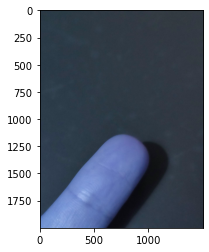